# Time-Series Econometrics Final Project
#### Author: Daniil Mikhailovskii

- Data source: World Bank (WDI): https://databank.worldbank.org/reports.aspx?source=2&series=SL.UEM.TOTL.NE.ZS&country=# 
- Country: United States
- Period: 1975–2024
- Frequency: Annual


## Research Question

##### What are the dynamic interactions between economic growth, inflation, and unemployment in the United States, and how do shocks to one variable affect the others over time?

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [ ]:
import pandas as pd


df_raw = pd.read_csv("/Users/user/Downloads/P_Data_Extract_From_World_Development_Indicators (2)/33fc69b7-b3a0-45be-80a7-b2f173bf0b0c_Data.csv")
df_raw = df_raw.drop(labels=[3,4,5,6,7], axis=0)
df_raw.head()


,Series Name,Series Code,Country Name,Country Code,1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,United States,USA,8.500000,7.700000,7.100000,6.100000,5.800000,7.100000,...,5.280000,4.869000,4.355000,3.896000,3.669000,8.055000,5.349000,3.650000,3.638000,4.022000
1,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,United States,USA,9.143147,5.744813,6.501684,7.630964,11.254471,13.549202,...,0.118627,1.261583,2.130110,2.442583,1.812210,1.233584,4.697859,8.002800,4.116338,2.949525
2,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,United States,USA,-0.205619,5.388034,4.624187,5.535206,3.165988,-0.256776,...,2.945550,1.819451,2.457622,2.966505,2.583825,-2.163029,6.055053,2.512375,2.887556,2.793001


In [ ]:
# Keep only the USA rows
df_raw = df_raw[df_raw["Country Code"] == "USA"]

# Identify year columns automatically
year_cols = [c for c in df_raw.columns if "[YR" in c]

df_raw = df_raw[["Series Name"] + year_cols]


In [ ]:
# Convert from wide to long format
df_long = df_raw.melt(
    id_vars="Series Name",
    value_vars=year_cols,
    var_name="year",
    value_name="value"
)

# Extract numeric year
df_long["year"] = df_long["year"].str.extract(r"(\d{4})").astype(int)
df_long = df_long.reset_index()


In [23]:
# Pivot so that each variable is a column
df_ts = df_long.pivot(
    index="year",
    columns="Series Name",
    values="value"
)

df_ts = df_ts.sort_index()
df_ts.columns.name = None

# df_ts = df_ts.rename(columns={"year": "Year"})
df_ts.head()


,GDP growth (annual %),"Inflation, consumer prices (annual %)","Unemployment, total (% of total labor force) (national estimate)"
year,,,
1975,-0.205619,9.143147,8.5
1976,5.388034,5.744813,7.7
1977,4.624187,6.501684,7.1
1978,5.535206,7.630964,6.1
1979,3.165988,11.254471,5.8


In [24]:
df_ts = df_ts.rename(columns={
    "GDP growth (annual %)": "gdp_growth",
    "Inflation, consumer prices (annual %)": "inflation",
    "Unemployment, total (% of total labor force) (national estimate)": "unemployment"
})

# Convert to numeric
df_ts = df_ts.apply(pd.to_numeric, errors="coerce")

df_ts = df_ts.dropna()
df_ts.head()


,gdp_growth,inflation,unemployment
year,,,
1975,-0.205619,9.143147,8.5
1976,5.388034,5.744813,7.7
1977,4.624187,6.501684,7.1
1978,5.535206,7.630964,6.1
1979,3.165988,11.254471,5.8


## Stationary test

### 2.1 Visual Inspection

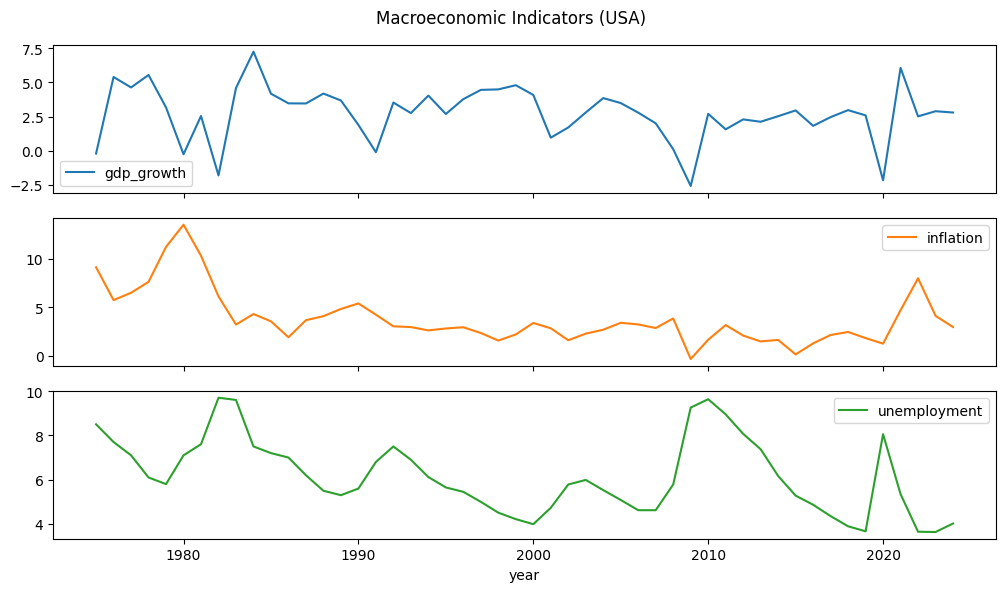

In [26]:
df_ts.plot(subplots=True, figsize=(10, 6))
plt.suptitle("Macroeconomic Indicators (USA)")
plt.tight_layout()
plt.show()


Observation:

- GDP growth fluctuates around zero → likely stationary
- Inflation and unemployment display persistence

### 2.2 Stationarity Tests (ADF)

In [33]:
def adf_test(series, name):
    res = adfuller(series)
    print(f"{name}: ADF p-value = {res[1]:.4f}")

for col in df_ts.columns:
    adf_test(df_ts[col], col)


gdp_growth: ADF p-value = 0.0000
inflation: ADF p-value = 0.0551
unemployment: ADF p-value = 0.0214


Conclusion:

- GDP growth is stationary
- Inflation and unemployment are borderline non-stationary

### 2.3 First Differences

In [34]:
df_diff = df_ts.diff().dropna()

for col in df_diff.columns:
    adf_test(df_diff[col], f"Δ{col}")

Δgdp_growth: ADF p-value = 0.0000
Δinflation: ADF p-value = 0.0000
Δunemployment: ADF p-value = 0.0000


All differenced series are stationary → VAR in differences is appropriate.

-------

### 3.1 Lag Length Selection

In [35]:
model = VAR(df_diff)
lag_selection = model.select_order(maxlags=5)
print(lag_selection.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       2.736       2.857       15.42       2.781
1      1.336*      1.822*      3.808*      1.516*
2       1.440       2.292       4.257       1.756
3       1.471       2.687       4.459       1.922
4       1.459       3.041       4.543       2.046
5       1.647       3.593       5.762       2.368
-------------------------------------------------


/Users/user/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


### 3.2 VAR Estimation

In [36]:
var_res = model.fit(1)
print(var_res.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Dec, 2025
Time:                     18:11:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    1.86919
Nobs:                     48.0000    HQIC:                   1.57817
Log likelihood:          -225.960    FPE:                    4.06555
AIC:                      1.40139    Det(Omega_mle):         3.19766
--------------------------------------------------------------------
Results for equation gdp_growth
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.045147         0.276846            0.163           0.870
L1.gdp_growth          -0.167207         0.126579           -1.321           0.187
L1.inflation           -0.179900         0.1773

### 3.3 Stability Check

In [37]:
var_res.is_stable(verbose=True)


Eigenvalues of VAR(1) rep
0.4353463313909969
0.4353463313909969
0.16143902471568847


True

## Post-Estimation Analysis

### 4.1 Impulse Response Functions (IRFs)

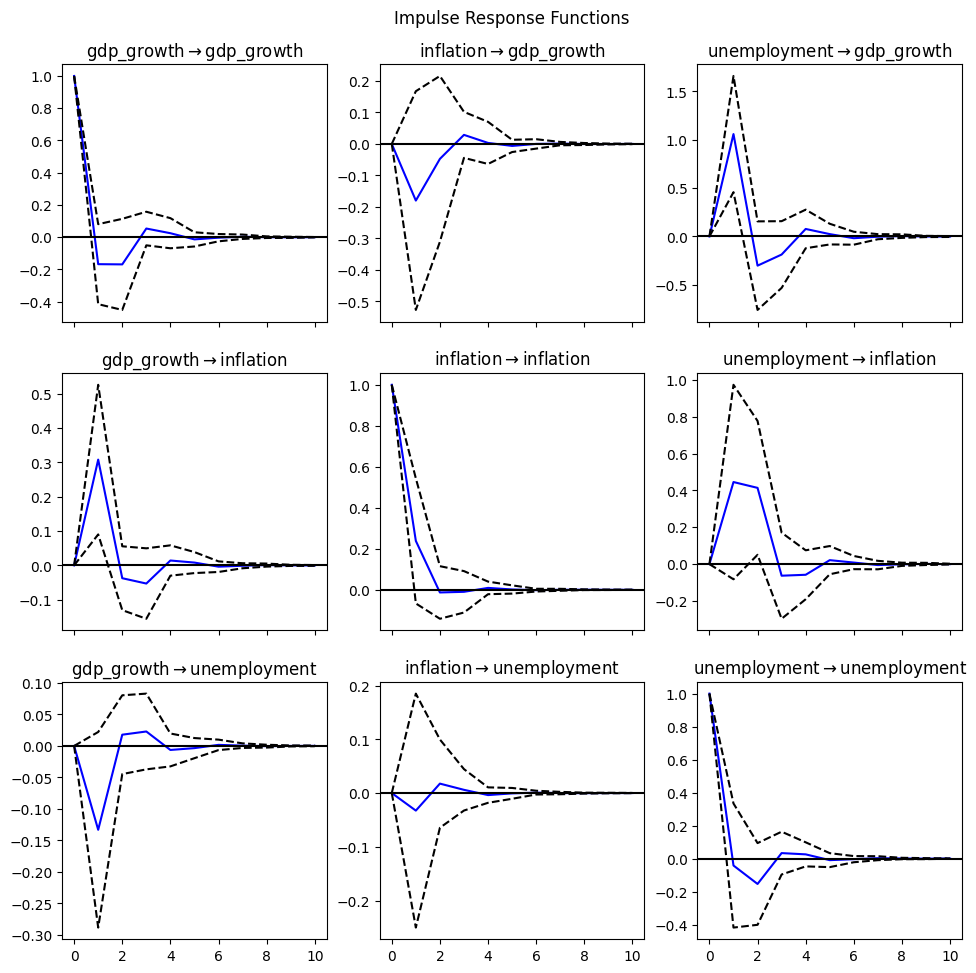

In [38]:
irf = var_res.irf(10)
irf.plot(orth=False)
plt.suptitle("Impulse Response Functions")
plt.show()

### 5. Forecasting

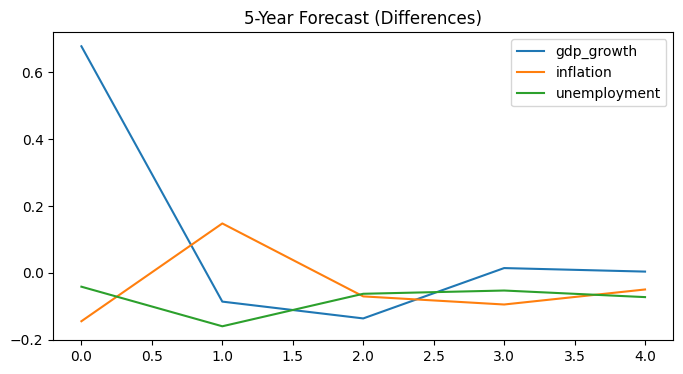

In [39]:
forecast = var_res.forecast(
    df_diff.values[-1:], steps=5
)

forecast_df = pd.DataFrame(
    forecast,
    columns=df_diff.columns
)

forecast_df.plot(figsize=(8, 4))
plt.title("5-Year Forecast (Differences)")
plt.show()
